# Austin Building: Booming or Busting?

Recently my brother-in-law moved into town and started looking for apartments to rent and I was astounded at how much more expensive the rates are now (September 2021) than just a year ago when I was pricing apartments for myself. With the continued population growth of the city I initially assumed that the price increase was due to high demand. However, looking around at all the large-scale new construction happening, I began to wonder if there was also a supply issue at play due to decreased building during the pandemic. Most of these large-scale projects take years between permit approval and being tenant ready, and I wondered if the pandemic had caused delays in new buildings being brought to market contributing to the current supply shortage, but if there might also be a big spike in supply soon as these buildings that had big delays are able to finish construction and come to market.

The data that I have used for my analysis so far came from the City of Austin [website](https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu). I downloaded the dataset as a csv file and imported it into this notebook for analysis. Several people have made great visualizations from this data that are findable from the download page, but I have not seen anything like this analysis.

Each row of this dataset represents a building permit issued from the city of Austin and contains several different pieces of information about the project that the permit was issued for. The question I am asking for this project is "how has the covid pandemic effected the housing supply in Austin?" My hypothesis is that the a large amount of projects that were either starting or under way when the pandemic started experience abnormal, prolonged delays contributing to current housing supply shortage. But now that the market has accommodated that shortage with price increases and those projects are back online, I anticipate that we could see a housing supply surplus in the near future. There are a ton of other factors at play here, including continued pandemic effects, political issues, inflation, and even the looming demise of a massive Chinese real estate investment firm, but I will be solely looking into the building supply. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline

In [2]:
# set chart theme
sns.set_theme(context='notebook', style='darkgrid', 
                  palette='deep', font='sans-serif', font_scale=1.3, color_codes=True, rc=None)

# set pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# turning off warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# warning issue that cols. 53-65 have mixed dtypes. I might want to specify if I want that data later.

df = pd.read_csv("Issued_Construction_Permits.csv", low_memory=False)
df.head(1)

,Permit Type,Permit Type Desc,Permit Num,Permit Class Mapped,Permit Class,Work Class,Condominium,Project Name,Description,TCAD ID,Property Legal Description,Applied Date,Issued Date,Day Issued,Calendar Year Issued,Fiscal Year Issued,Issued In Last 30 Days,Issuance Method,Status Current,Status Date,Expires Date,Completed Date,Total Existing Bldg SQFT,Remodel Repair SQFT,Total New Add SQFT,Total Valuation Remodel,Total Job Valuation,Number Of Floors,Housing Units,Building Valuation,Building Valuation Remodel,Electrical Valuation,Electrical Valuation Remodel,Mechanical Valuation,Mechanical Valuation Remodel,Plumbing Valuation,Plumbing Valuation Remodel,MedGas Valuation,MedGas Valuation Remodel,Original Address 1,Original City,Original State,Original Zip,Council District,Jurisdiction,Link,Project ID,Master Permit Num,Latitude,Longitude,Location,Contractor Trade,Contractor Company Name,Contractor Full Name,Contractor Phone,Contractor Address 1,Contractor Address 2,Contractor City,Contractor Zip,Applicant Full Name,Applicant Organization,Applicant Phone,Applicant Address 1,Applicant Address 2,Applicant City,Applicant Zip,Certificate Of Occupancy,Total Lot SQFT
0,BP,Building Permit,1986-024190 BP,Commercial,Commercial,Remodel,No,4700 Congress Avenue South A 00000,Repairs To Min Standard For 90 DaysMotel,NaN,NaN,1986/09/30,1986/09/30,TUESDAY,1986,1986,No,Permit Center,Expired,06/06/2007,1987/03/29,1987/03/29,NaN,NaN,NaN,NaN,50.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S CONGRESS AVE,AUSTIN,TX,NaN,NaN,NaN,https://abc.austintexas.gov/web/permit/public-search-other?t_detail=1&t_selected_folderrsn=570539,570539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN


### Adding a Year Complete column

To identify the construction delay I am going to look only at new construction projects that provide "housing units". A housing unit can be a house, condominium, apartment, etc, and can house either an individual or a collection of people, is not a business facility or other non-residentail building. For each new construction project there is a permit issue date, a date of completion and the number of housing units the building will provide. I am going to start by looking at the number of housing units that get a permit each year compared to the number of housing units that are completed each year.

In [4]:
# adding integer column for year complete
def year_complete(date):
    try:
        date = date.split('/')[0]
        date = int(date)
        return date
    except:
        return date

df['Year Completed'] = df['Completed Date'].apply(year_complete)

In [5]:
# selecting the permits to avoid redundancy & non-residential buildings
permit_classes = ['C- 101 Single Family Houses', 'C- 103 Two Family Bldgs', 'C- 104 Three & Four Family Bldgs', 
                  'C- 105 Five or More Family Bldgs', 'C- 106 Mixed Use', 'R- 101 Single Family Houses', 
                  'R- 102 Secondary Apartment', 'R- 103 Two Family Bldgs', 'R- 436 Addn to increase housing units']

# a filter for housing units by permit issue date
mask =  (df['Permit Class'].isin(permit_classes)) & (df['Permit Type']=='BP') & (df['Certificate Of Occupancy']=='Yes')\
        & (df['Work Class'].isin(['New', 'Shell']))& (df['Status Current'].isin(['Final', 'Active'])) 

apply_date = df[mask].groupby(['Calendar Year Issued']).sum() 
# this is  the df for units by permit issue year
yearly_permit_units = apply_date['Housing Units']

# a filter for housing units by completion year
mask =  (df['Permit Class'].isin(permit_classes)) & (df['Permit Type']=='BP') & (df['Certificate Of Occupancy']=='Yes')\
        & (df['Work Class'].isin(['New', 'Shell'])) & (df['Status Current']=='Final')

final_date = df[mask].groupby(['Year Completed']).sum()
# this is the df for units by completion year
final_permit_units = final_date['Housing Units']

# a filter for housing units permitted since 2019 that have not been completed
issue_years = [2019,2020,2021]
mask =  (df['Calendar Year Issued'].isin(issue_years)) & (df['Permit Class'].isin(permit_classes)) & (df['Permit Type']=='BP') & (df['Certificate Of Occupancy']=='Yes')\
        & (df['Work Class'].isin(['New', 'Shell'])) & (df['Status Current'].isin(['Active']))

active_permits = df[mask].groupby(['Calendar Year Issued']).sum()
# this is the total of housing units permitted since 2019 that have not been completed
active_permit_units = active_permits['Housing Units'].sum()

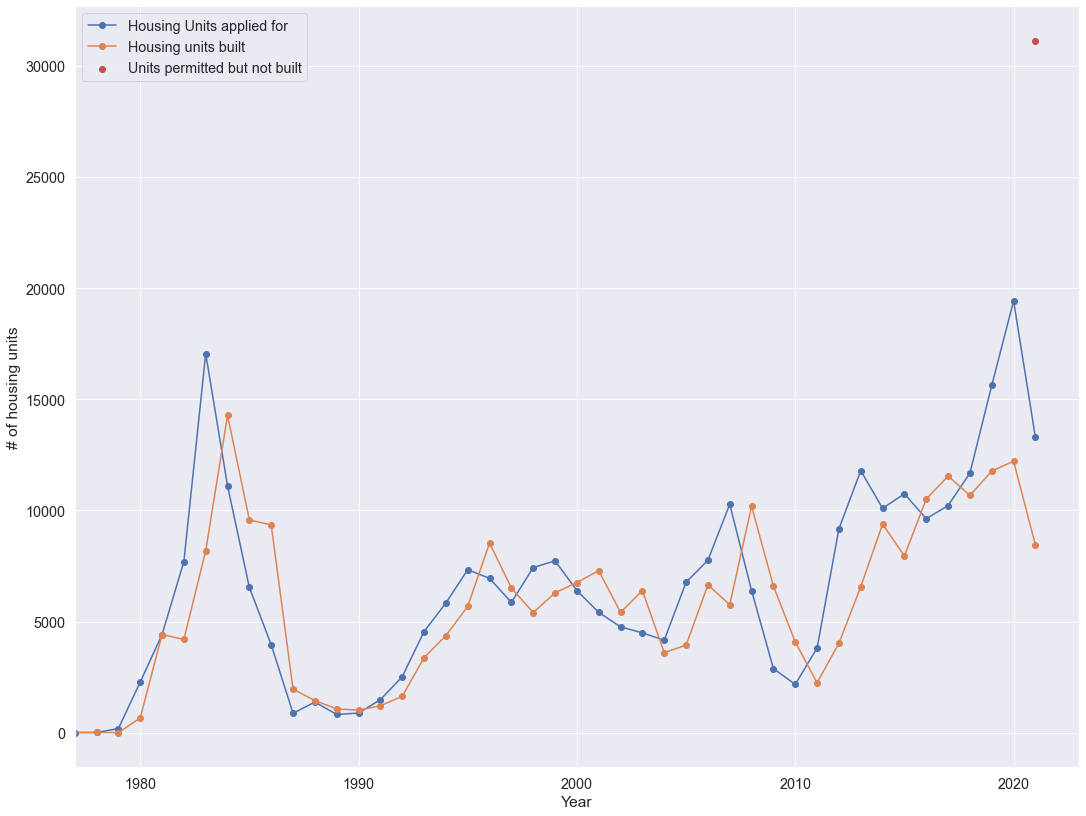

In [6]:
# Visualizing the data 

plt.figure(figsize=(18,14))
# units permited per year
plt.plot(yearly_permit_units.index, yearly_permit_units, label='Housing Units applied for', marker='o')
# units finished per year
plt.plot(final_permit_units.index, final_permit_units, label='Housing units built', marker='o')
# unfinished units
plt.scatter(2021,active_permit_units, color='r', label='Units permitted but not built')


plt.legend()
# There were few permits issued before 1977
plt.xlim([1977, 2023])
plt.xlabel('Year')
plt.ylabel('# of housing units')

plt.show()

### Bucking the Trend

There is a clear pattern that the units completed peak follows the units permitted peak by a year or two, and this is about what I expected to see. However, while the units permitted in 2020 shot to an all time high, the units completed barely budged and is still massively low so far in 2021. While previous booms in the early 80's and late 2000's the units finished peaked nearly as high as the units issued, this year has not even come close. 

## Takeaways

So far, this graph seems to confirm my suspicion that the building supply has not kept up with demand, so my next step will be to look into modeling completion forcast for buildings with active permits to see if I can predict when (or if) the housing supply will catch up to demand. 

Other ideas I would like to explore in this project or in the future:
- How does this chart compare to Austin's annual population growth? (indivduals or households)
- How does this chart compare to Austin's real estate or rental pricing?
- What does it look like to chart the cumulative housing units rather than just new annual. (Stock to flow ratio)
- How does Austin's building cycle compare to other metropolitan areas?